In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import pickle
import sys
sys.path.append('..')

In [2]:
notebook_name = os.path.basename(os.getcwd())
timestamp="07"

In [3]:
version="_ver2.1"

In [4]:
path_movie_dir = '../data/movie/'
path_save_dir = os.path.join('../data/06_Evaluation'+version+'/', timestamp)
if not os.path.exists(path_save_dir):
    os.makedirs(path_save_dir)
#path_save_file = os.path.join(path_save_dir, 'test_data.csv')
path_save_file = os.path.join(path_save_dir, 'test.csv')

In [12]:
path_label_name_file = '../data/labels/labels_num'+version+'.csv'
path_action_dir = os.path.join('../data/01_DataProcessing/', timestamp)
path_point_dir = os.path.join('../data/02_GetPoints'+version+'/', timestamp)
path_split_dir = os.path.join('../data/04_Split'+version+'/', timestamp)
path_test_file_dir = os.path.join(path_split_dir, 'test')
path_test_file = os.path.join(path_test_file_dir, 'test.csv')
path_model_dir = os.path.join('../data/05_train'+version+'/', timestamp)
path_model_file = os.path.join(path_model_dir, 'model.pkl')

In [13]:
file_names = ['fall','sitdown', 'standup']
# file_names = ['forehand']
movie_names = [file_name + '.MOV' for file_name in file_names]
points_file_names = [file_name +version+ '.csv' for file_name in file_names]

In [14]:
path_split_dir = os.path.join('../data/04_Split'+version+'/', timestamp)
path_test_file_dir = os.path.join(path_split_dir, 'test')

In [15]:
objective = 'action_gt_num'

In [16]:
label_names = pd.read_csv(path_label_name_file)

In [17]:
label_names

,action_gt_name,action_gt_num
0,idle,0
1,stand,1
2,fall,2
3,sitdown,3


In [18]:

gbm = pickle.load(open(path_model_file, "rb"))
path_model_file

'../data/05_train_ver2.1/07\\model.pkl'

In [19]:
feature_name_list = gbm.feature_name()

In [20]:
target_columns = ['RShoulder_x','RShoulder_y','RHip_x','RHip_y','RKnee_x','RKnee_y',
                  'Neck_x','Neck_y','Nose_x','Nose_y','LShoulde_x','LShoulde_y',
                  'LHip_x','LHip_y','LKnee_x','LKnee_y']

In [21]:
frame_length = 15
assert frame_length == int(len(feature_name_list) / len(target_columns))
frame_length

15

In [22]:
new_data_df = None
for num, points_file_name in enumerate(points_file_names):
    print(points_file_name)
    path_file = os.path.join(path_test_file_dir, points_file_name)
    data_df = pd.read_csv(path_file, index_col='frame_num')
    units_df = None
    for idx in data_df.index[frame_length:len(data_df)]:
        unit_df = data_df.loc[idx - frame_length: idx-1]
        y = unit_df[objective]
        Y=y.loc[idx-1]
        X = unit_df.drop(columns=[objective]).loc[:, target_columns]
        flatten_data=X.to_numpy().reshape(1,-1)
        A=['RShoulder_x','RShoulder_y', 'RHip_x', 'RHip_y','RKnee_x',
 'RKnee_y', 'Neck_x', 'Neck_y', 'Nose_x', 'Nose_y', 'LShoulde_x', 'LShoulde_y',
 'LHip_x', 'LHip_y', 'LKnee_x', 'LKnee_y']
        B=[a+"_"+str(i-14) for i in range(15) for a in A]
        X=pd.DataFrame(flatten_data,columns=B)
        X["action_gt_num"]=Y
        unit_df = X
        if units_df is None:
            units_df = unit_df
        else:
            units_df = pd.concat([units_df, unit_df], axis=0, sort=False)
    path_save_file = os.path.join(path_save_dir, points_file_name)
    units_df.to_csv(path_save_file)
    if new_data_df is None:
        new_data_df = units_df
    else:
        new_data_df = pd.concat([new_data_df, units_df], axis=0, sort=False)
test_data_df = new_data_df.copy()
test_data_df.to_csv(path_test_file)

fall_ver2.1.csv
sitdown_ver2.1.csv
standup_ver2.1.csv


In [23]:
test_data_df.groupby(objective).count()

,RShoulder_x_-14,RShoulder_y_-14,RHip_x_-14,RHip_y_-14,RKnee_x_-14,RKnee_y_-14,Neck_x_-14,Neck_y_-14,Nose_x_-14,Nose_y_-14,...,Neck_x_0,Neck_y_0,Nose_x_0,Nose_y_0,LShoulde_x_0,LShoulde_y_0,LHip_x_0,LHip_y_0,LKnee_x_0,LKnee_y_0
action_gt_num,,,,,,,,,,,,,,,,,,,,,
0,281,281,281,281,281,281,281,281,281,281,...,281,281,281,281,281,281,281,281,281,281
1,262,262,262,262,262,262,262,262,262,262,...,262,262,262,262,262,262,262,262,262,262
2,247,247,247,247,247,247,247,247,247,247,...,247,247,247,247,247,247,247,247,247,247
3,296,296,296,296,296,296,296,296,296,296,...,296,296,296,296,296,296,296,296,296,296


In [24]:
test_data_df['dummy'] = 1
test_data_df.groupby(objective).count()['dummy']

action_gt_num
0    281
1    262
2    247
3    296
Name: dummy, dtype: int64

In [25]:
X_test_data_df = test_data_df.drop([objective], axis=1)
y_test_data_df = test_data_df[objective]

In [26]:
y_pred = gbm.predict(X_test_data_df, num_iteration=gbm.best_iteration)
y_pred = np.argmax(y_pred, axis=1)

In [27]:
objective_pred = 'action_pred_num'

In [28]:
test_data_df[objective_pred] = y_pred
test_data_df = test_data_df.reset_index(drop=True)

In [29]:
accuracy_all = np.sum(test_data_df[objective] == test_data_df[objective_pred]) / len(test_data_df)


In [30]:
print('accuracy: ', round(accuracy_all*100, 2), ' %')


accuracy:  44.94  %


In [31]:
objective_rev_dict = label_names.to_dict()['action_gt_name']


In [32]:
test_data_df['action_gt_name'] = test_data_df[objective].apply(lambda x: objective_rev_dict[x])
test_data_df['action_pred_name'] = test_data_df[objective_pred].apply(lambda x: objective_rev_dict[x])


In [33]:
test_data_df.columns


Index(['RShoulder_x_-14', 'RShoulder_y_-14', 'RHip_x_-14', 'RHip_y_-14',
       'RKnee_x_-14', 'RKnee_y_-14', 'Neck_x_-14', 'Neck_y_-14', 'Nose_x_-14',
       'Nose_y_-14',
       ...
       'LShoulde_y_0', 'LHip_x_0', 'LHip_y_0', 'LKnee_x_0', 'LKnee_y_0',
       'action_gt_num', 'dummy', 'action_pred_num', 'action_gt_name',
       'action_pred_name'],
      dtype='object', length=245)

In [34]:
from sklearn.metrics import confusion_matrix

In [35]:
objective_names = list(objective_rev_dict.values())
objective_names

['idle', 'stand', 'fall', 'sitdown']

In [36]:
confusion_matrix_df = confusion_matrix(test_data_df[objective], test_data_df[objective_pred])


In [37]:
objective_names_pred = [objective_name + '_pred' for objective_name in objective_names]
objective_names_gt = [objective_name + '_gt' for objective_name in objective_names]

In [38]:
confusion_matrix_df

array([[226,  30,   7,  18],
       [132, 122,   8,   0],
       [117,  16,  97,  17],
       [ 68,  18, 167,  43]], dtype=int64)

In [39]:
confusion_matrix_df = pd.DataFrame(confusion_matrix_df, columns=objective_names_pred, index=objective_names_gt)
confusion_matrix_df

,idle_pred,stand_pred,fall_pred,sitdown_pred
idle_gt,226,30,7,18
stand_gt,132,122,8,0
fall_gt,117,16,97,17
sitdown_gt,68,18,167,43


In [40]:
# Precision
confusion_matrix_df / confusion_matrix_df.sum(axis=0) * 100

,idle_pred,stand_pred,fall_pred,sitdown_pred
idle_gt,41.620626,16.129032,2.508961,23.076923
stand_gt,24.309392,65.591398,2.867384,0.000000
fall_gt,21.546961,8.602151,34.767025,21.794872
sitdown_gt,12.523020,9.677419,59.856631,55.128205


In [41]:
# Recall
(confusion_matrix_df.T / confusion_matrix_df.sum(axis=1)).T * 100

,idle_pred,stand_pred,fall_pred,sitdown_pred
idle_gt,80.427046,10.676157,2.491103,6.405694
stand_gt,50.381679,46.564885,3.053435,0.000000
fall_gt,47.368421,6.477733,39.271255,6.882591
sitdown_gt,22.972973,6.081081,56.418919,14.527027


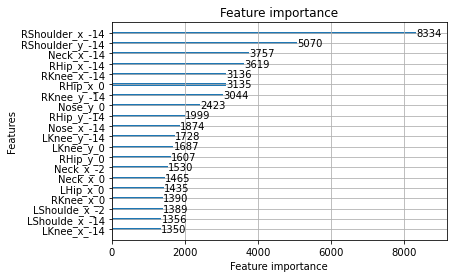

In [42]:
lgb.plot_importance(gbm, max_num_features=20)
